# Imports und Konfigurationen

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import locale
import tkinter as tk
from tkinter import ttk
from windrose import WindroseAxes
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.stats import weibull_min

# Lokales Datumsformat auf Deutsch setzen 
locale.setlocale(locale.LC_TIME, "de_DE.utf8")



'de_DE.utf8'

# Interface

In [25]:
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import os

# Create a tkinter window
window = tk.Tk()

# Define function to process the inputs
def process_inputs():
    global alpha, z0, h, required_power, option, file_name
    alpha = float(entry_alpha.get())
    z0 = float(entry_z0.get())
    h = float(entry_h.get())
    required_power = float(entry_required_power.get())
    option = combo_option.get()
    file_name = entry_file_name.get()
    
    if alpha < 0 or alpha > 2:
        messagebox.showerror("Invalid Input", "Alpha value must be between 0 and 10.")
        return
    
    if z0 < 0:
        messagebox.showerror("Invalid Input", "z0 value must be positive.")
        return
    
    if h < 0:
        messagebox.showerror("Invalid Input", "h value must be positive.")
        return
    
    if required_power < 0 or required_power > 250:
        messagebox.showerror("Invalid Input", "Required power value must be between 0 and 250.")
        return
    
    if not alpha or not z0 or not h or not required_power or not option or not file_name:
        messagebox.showerror("Missing Input", "Please fill in all required fields.")
        return
    
    try:
        alpha = float(alpha)
        z0 = float(z0)
        h = float(h)
        required_power = float(required_power)
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter valid numeric values.")
        return

    # Check if the file exists
    if not os.path.isfile(file_name):
        messagebox.showerror("File Not Found", "The specified file does not exist in the directory.")
        return

    window.destroy()  # Close the window

    # Continue with the rest of the code
    # ...

# Create labels and entry fields for inputs
label_alpha = tk.Label(window, text="Alpha:")
label_alpha.pack()
entry_alpha = tk.Entry(window)
entry_alpha.pack()

label_z0 = tk.Label(window, text="z0:")
label_z0.pack()
entry_z0 = tk.Entry(window)
entry_z0.pack()

label_h = tk.Label(window, text="h[m]:")
label_h.pack()
entry_h = tk.Entry(window)
entry_h.pack()

label_required_power = tk.Label(window, text="Required Power[kW]:")
label_required_power.pack()
entry_required_power = tk.Entry(window)
entry_required_power.pack()

# Create a dropdown menu for an option

label_file_name = tk.Label(window, text="Enter File Name:")
label_file_name.pack()
entry_file_name = tk.Entry(window)
entry_file_name.pack()

label_option = tk.Label(window, text="Choose Weather Datasource:")
label_option.pack()
combo_option = ttk.Combobox(window, values=["Merra", "Era5", "DWD"])
combo_option.pack()

# Create a button to submit the inputs
submit_button = tk.Button(window, text="Submit", command=process_inputs)
submit_button.pack()

# Check if the window is closed without entering data
window.protocol("WM_DELETE_WINDOW", lambda: messagebox.showerror("Missing Input", "Please fill in all required fields."))

# Run the tkinter event loop
window.mainloop()

# Show a confirmation message
if all((alpha, z0, h, required_power, option, file_name)):
    messagebox.showinfo("Input Received", "Variable values have been entered")


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\greif\anaconda3\envs\WEA\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\greif\AppData\Local\Temp\ipykernel_17392\4256163001.py", line 14, in process_inputs
    h = float(entry_h.get())
        ^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: ''
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\greif\anaconda3\envs\WEA\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\greif\AppData\Local\Temp\ipykernel_17392\4256163001.py", line 14, in process_inputs
    h = float(entry_h.get())
        ^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: ''
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\greif\anaconda3\envs\WEA\Lib\tkinter\__init__.py", line 1948, in __call__
  

# Daten einlesen und vorbereiten

In [17]:
# Lese die Daten aus der Datei ein
winddaten_df = pd.read_csv("data\produkt_ff_stunde_20211202_20230430_00125.txt", delimiter=";")

# Konvertiere die MESS_DATUM-Spalte in einen String
winddaten_df["MESS_DATUM"] = winddaten_df["MESS_DATUM"].astype(str)

# Aufsplitten des MESS_DATUM in separate Spalten
winddaten_df["Jahr"] = winddaten_df["MESS_DATUM"].str[:4].astype(int)
winddaten_df["Monat"] = winddaten_df["MESS_DATUM"].str[4:6].astype(int)
winddaten_df["Tag"] = winddaten_df["MESS_DATUM"].str[6:8].astype(int)
winddaten_df["Stunde"] = winddaten_df["MESS_DATUM"].str[8:10].astype(int)

# Umwandlung der MESS_DATUM-Spalte in ein DateTime-Format
winddaten_df['MESS_DATUM'] = pd.to_datetime(winddaten_df['MESS_DATUM'], format='%Y%m%d%H')

# Umbenennen der verbleibenden Spalten für Konsistenz
winddaten_df = winddaten_df.rename(columns={"STATIONS_ID": "StationID", "   F": "F", "   D": "D"})

# Daten für Leistungskurve aus der zweiten Datei einlesen 
filename2 = 'data\Leistungskurven.txt'
leistungskurve_df = pd.read_csv(filename2, delimiter='\t')

# Daten aus Datei einlesen
filename = "data\Daten_WKA.txt"
Daten_WKA_df = pd.read_csv(filename, delimiter='\t')

# zweites Feld Kommentar

# Userinput Datei einlesen

In [18]:
# Extrahieren der einzelnen Werte
rauhigkeitslaenge = 0.05
nabenhoehe = 80
mindestleistung = 100

# Ausgabe der eingelesenen Werte
print('Rauhigkeitslänge: [-]', rauhigkeitslaenge)
print('Nabenhöhe: [m]', nabenhoehe)
print('Mindestleistung: [W]', mindestleistung)


Rauhigkeitslänge: [-] 0.05
Nabenhöhe: [m] 80
Mindestleistung: [W] 100


# Winddaten anpassen

In [19]:
# Multipliziere Winddaten mit den entsprechenden Faktoren für jede Turbine
turbine_spalten = leistungskurve_df.columns[1:]

def adjust_wind_speed(roughness_length, hub_height):
    """
    Funktion zur Anpassung der Windgeschwindigkeit von der Messhöhe 10 m auf die Nabenhöhe der Turbine.

    Args:
        wind_speed (float): Windgeschwindigkeit in m/s an der Messhöhe von 10 m.
        roughness_length (float): Rauhigkeitslänge der Umgebung in Metern.
        hub_height (float): Nabenhöhe der Turbine in Metern.

    Returns:
        float: Angepasste Windgeschwindigkeit in m/s auf der Nabenhöhe der Turbine.
    """
    return (np.log(hub_height / roughness_length) / np.log(10 / roughness_length))

for turbine in turbine_spalten:
    winddaten_df[turbine] = winddaten_df["F"]
    Faktor = adjust_wind_speed(rauhigkeitslaenge, nabenhoehe)
    for i in range(len(winddaten_df['F'])):
        winddaten_df.loc[i,turbine] = leistungskurve_df.iloc[(np.abs(leistungskurve_df['Speed'] - (winddaten_df['F'][i]*Faktor)).idxmin())][turbine]*Daten_WKA_df[turbine][0]

# Benutzeroberfläche (GUI) erstellen

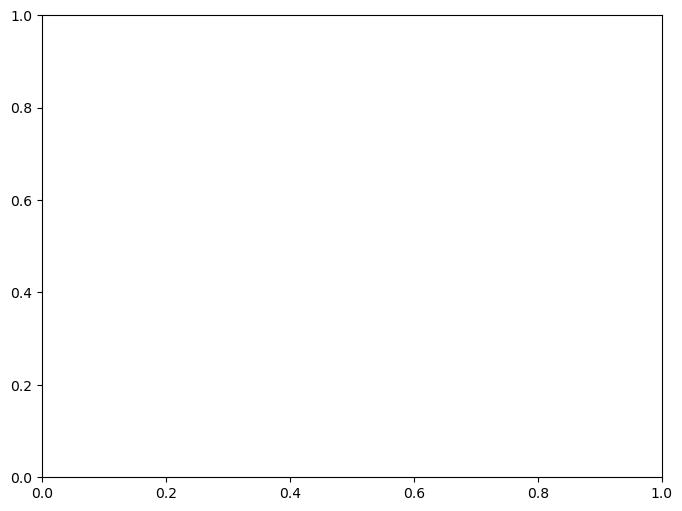

In [20]:
turbine_list = leistungskurve_df.columns[1:].str.strip().tolist()  # Turbinennamen bereinigen

# Funktion zum Aktualisieren des Graphen basierend auf der ausgewählten Turbine
def update_graph():
    selected_turbine = turbine_combo.get()
    if selected_turbine:
        graph.clear()
        graph.plot(winddaten_df['MESS_DATUM'], winddaten_df[selected_turbine], label=selected_turbine)

        # Achsenbeschriftungen und Titel hinzufügen
        graph.set_xlabel('Datum und Uhrzeit')
        graph.set_ylabel('Leistung')
        graph.set_title(f'Leistung der Turbine {selected_turbine} über die Zeit')

        # Datumsformat für die x-Achse festlegen
        date_format = "%d-%b-%Y %H:%M"
        graph.xaxis.set_major_formatter(mdates.DateFormatter(date_format))

        # Automatische Anpassung des Layouts
        graph.figure.autofmt_xdate()

        # Legende anzeigen
        graph.legend()

        # Graph anzeigen
        canvas.draw()

# GUI erstellen
root = tk.Tk()
root.title("Leistung der Turbine über die Zeit")

# Graph erstellen
fig = plt.figure(figsize=(8, 6))
graph = fig.add_subplot(1, 1, 1)
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack()


# Frame erstellen
frame = ttk.Frame(root)
frame.pack(pady=10)

# Dropdown-Menü für Turbinenauswahl erstellen
turbine_label = ttk.Label(frame, text="Turbine auswählen:")
turbine_label.pack(side="left", padx=5)
turbine_combo = ttk.Combobox(frame, values=turbine_list, state="readonly")
turbine_combo.pack(side="left", padx=5)
turbine_combo.bind("<<ComboboxSelected>>", lambda event: update_graph())

# Initialen Graph anzeigen
update_graph()

# GUI starten
root.mainloop()

# Windrose und Windrichtungs-Verteilung plotten

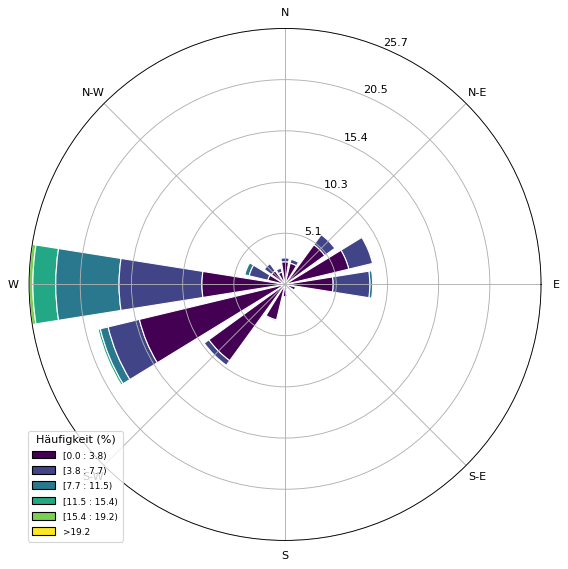

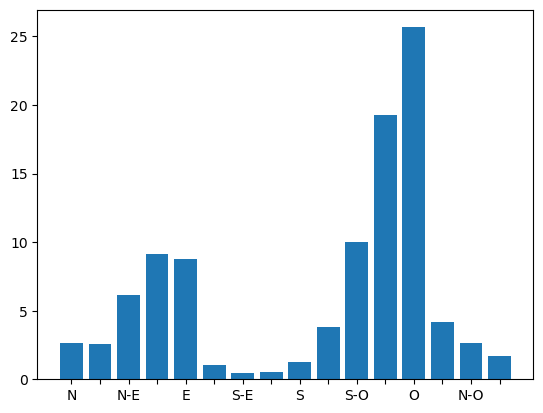

In [21]:


# Winddaten aus DataFrame lesen
data = winddaten_df.copy()

# Windrichtungen und Geschwindigkeiten definieren
directions = data['D']
speeds = data['F']

# Werte unter 0 auf NaN setzen
speeds = speeds.copy()
directions = directions.copy()

speeds.loc[speeds < 0] = np.nan
directions.loc[directions < 0] = np.nan

from matplotlib import cm


# Windrose plotten
ax = WindroseAxes.from_ax()
ax.bar(directions, speeds, normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title='Häufigkeit (%)')


# Plot anzeigen
plt.show()


ax.bar(directions, speeds, normed=True, nsector=16)
table = ax._info["table"]
wd_freq = np.sum(table, axis=0)



import matplotlib.pyplot as plt

direction = ax._info["dir"]
wd_freq = np.sum(table, axis=0)

plt.bar(np.arange(16), wd_freq, align="center")
xlabels = (
    "N", "",
    "N-E", "",
    "E", "",
    "S-E", "",
    "S", "",
    "S-O", "",
    "O", "",
    "N-O", "",
)
xticks = np.arange(16)
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xlabels)
plt.show()

# Weibull Verteilung plotten: 

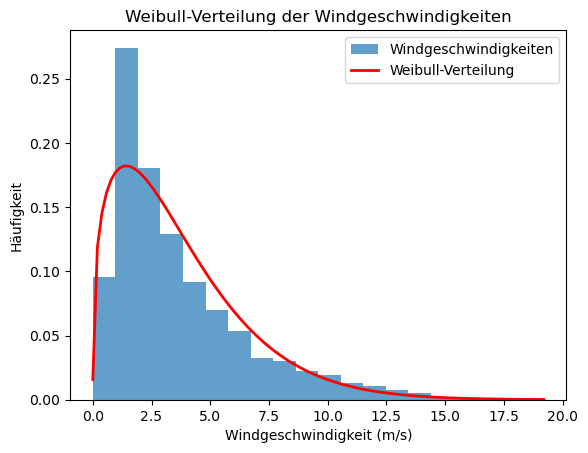

Weibull-Verteilungsfaktoren:
Formfaktor (Shape): 1.3316118545752684
Lagefaktor (Location): -0.000415707451063724
Skalenfaktor (Scale): 4.0319341680023975


In [22]:

# Winddaten aus DataFrame lesen
data = winddaten_df.copy()

# Windgeschwindigkeiten auslesen
wind_speeds = np.array(data['F'])

# Faktoren für Weibull-Verteilung berechnen
shape, loc, scale = weibull_min.fit(wind_speeds, loc=0)

# Weibull-Verteilung generieren
x = np.linspace(0, wind_speeds.max(), 100)
pdf = weibull_min.pdf(x, shape, loc=loc, scale=scale)

# Histogramm der Windgeschwindigkeiten plotten
plt.hist(wind_speeds, bins=20, density=True, alpha=0.7, label='Windgeschwindigkeiten')

# Weibull-Verteilung plotten
plt.plot(x, pdf, 'r-', lw=2, label='Weibull-Verteilung')

# Diagramm beschriften
plt.xlabel('Windgeschwindigkeit (m/s)')
plt.ylabel('Häufigkeit')
plt.title('Weibull-Verteilung der Windgeschwindigkeiten')
plt.legend()

# Plot anzeigen
plt.show()

# Ausgabe der Weibull-Faktoren
print('Weibull-Verteilungsfaktoren:')
print('Formfaktor (Shape):', shape)
print('Lagefaktor (Location):', loc)
print('Skalenfaktor (Scale):', scale)


# Berechnung der Mindesakkugröße und Bestimmung der Kosten für den Akku


In [23]:
def max_consecutive_no_power(data, turbine_columns, p_min, Daten_WKA_df):
    """
    Funktion zur Ermittlung der maximalen Zeit, in der hintereinander kein Strom von jeder Windkraftanlage erzeugt wird.
    Die Funktion fügt eine weitere Spalte hinzu, die die benötigte Akkugröße in kWh enthält.

    Args:
        data (DataFrame): DataFrame mit den Winddaten.
        turbine_columns (list): Liste der Spalten, die die Windkraftanlagen identifizieren.
        p_min (float): Grenzwert für die Stromerzeugung.

    Returns:
        DataFrame: DataFrame mit der maximalen Zeit, in der hintereinander kein Strom von jeder Windkraftanlage erzeugt wird und der benötigten Akkugröße.
    """
    max_consecutive = {}
    battery_sizes = {}
    Kosten_WEA = {}
    for turbine_column in turbine_columns:
        consecutive_hours = 0
        max_consecutive_hours = 0
        for _, row in data.iterrows():
            if row[turbine_column] <= 0.5 * p_min:  # p_min halbiert, stunde wird nur gezählt, wenn weniger als die hälfte von p_min produziert wird
                consecutive_hours += 1
                if consecutive_hours > max_consecutive_hours:
                    max_consecutive_hours = consecutive_hours
            else:
                consecutive_hours = 0
        max_consecutive[turbine_column] = max_consecutive_hours
        battery_sizes[turbine_column] = max_consecutive_hours * p_min * 1000 #in kWh
        Kosten_WEA[turbine_column] = Daten_WKA_df[turbine_column][0] * 4000 * 1000 # Nennleistung in MW mal 1000 für kW und mal 3000 für Preis/kW
    max_consecutive_df = pd.DataFrame({'Turbine': list(max_consecutive.keys()), 'MaxConsecutiveHours': list(max_consecutive.values()), 'Battery Size in kWh': list(battery_sizes.values()), 'Kosten WEA': list(Kosten_WEA.values())})
    max_consecutive_df['Kosten_Batterie_Euro'] = max_consecutive_df['Battery Size in kWh'] * 1200

    return max_consecutive_df

# Aufrufen der Funktion
p_min = mindestleistung / 1000000 # Grenzwert für die Stromerzeugung in MW
hours_without_power_df = max_consecutive_no_power(winddaten_df, turbine_list, p_min, Daten_WKA_df)
hours_without_power_df['Gesamtkosten in T€'] = (hours_without_power_df['Kosten WEA'] + hours_without_power_df['Kosten_Batterie_Euro']) / 1000
hours_without_power_df

,Turbine,MaxConsecutiveHours,Battery Size in kWh,Kosten WEA,Kosten_Batterie_Euro,Gesamtkosten in T€
0,Enercon_E44_900,28,2.8,3600000.0,3360.0,3603.36
1,Enercon_E48_800,28,2.8,3200000.0,3360.0,3203.36
2,Enercon_E53_800,28,2.8,3200000.0,3360.0,3203.36
3,Enercon_E70_2300,34,3.4,9200000.0,4080.0,9204.08
4,Enercon_E82_2000,29,2.9,8000000.0,3480.0,8003.48
5,Enercon_E82_2300,29,2.9,9200000.0,3480.0,9203.48
6,Enercon_E82_3000,29,2.9,12000000.0,3480.0,12003.48
7,Enercon_E92_2350,29,2.9,9400000.0,3480.0,9403.48
8,Enercon_E126_7500,38,3.8,30320000.0,4560.0,30324.56
9,GE_2.5xl,65,6.5,10000000.0,7800.0,10007.80


# Gesamtenergieertrag über den betrachteten Zeitraum in MWh

In [24]:

def calculate_total_energy(data, turbine_columns):
    """
    Funktion zur Berechnung des Gesamtenergieertrags für jede Windkraftanlage.

    Args:
        data (DataFrame): DataFrame mit den Winddaten.
        turbine_columns (list): Liste der Spalten, die die Windkraftanlagen identifizieren.

    Returns:
        DataFrame: DataFrame mit dem Gesamtenergieertrag für jede Windkraftanlage.
    """
    total_energy = {}
    for turbine_column in turbine_columns:
        total_energy[turbine_column] = data[turbine_column].sum()

    return pd.DataFrame({'Turbine': list(total_energy.keys()), 'TotalEnergy in MWh': list(total_energy.values())})

# Beispielaufruf der Funktion
total_energy = calculate_total_energy(winddaten_df, turbine_list)
total_energy


,Turbine,TotalEnergy in MWh
0,Enercon_E44_900,1723.842998
1,Enercon_E48_800,1884.497036
2,Enercon_E53_800,2061.566972
3,Enercon_E70_2300,4594.660568
4,Enercon_E82_2000,5004.196715
5,Enercon_E82_2300,5274.370417
6,Enercon_E82_3000,5807.255464
7,Enercon_E92_2350,5389.030643
8,Enercon_E126_7500,14400.472700
9,GE_2.5xl,6295.950677
